In [2]:
%matplotlib inline

import os
import glob
import json
import time
import math
import copy
import datetime

import bcolz
import numpy as np
import pandas as pd

from skimage import transform
from skimage import img_as_ubyte

from keras.utils import np_utils
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from IPython.display import display

import utils
import config

Using TensorFlow backend.


In [3]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [4]:
def read_relabels(path):
    # https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/forums/t/28150/unified-effort-to-relabel-the-training-set
    relabels = {}
    with open(path) as f:
        for line in f:
            cols = line.split()
            src = "{}/{}/{}.jpg".format(config.training_images_path, cols[1], cols[0])
            relabels[src] = cols[2]
    return relabels


def read_bbox_annotations(path):
    boxes = {}
    for c in classes:
        path = os.path.join(path, c + '.json')
        if os.path.isfile(path):
            class_boxes = utils.read_bbox_json(path)
            boxes.update(class_boxes)
    return boxes


def preprocess_img_data(img_arr):
    preprocess_input(img_arr)


def read_training_images(path, boxes, relabels):
    X_train = []
    y_train = []
    y_train_box = []

    t0 = time.time()
    print('Reading training images...')

    for c in classes:
        images = glob.glob(os.path.join(path, c, '*.jpg'))
        class_index = classes.index(c)
        print('Loading class: {}'.format(c))

        for img_path in images:
            # print('Reading: ', img_path)
            img_name = os.path.basename(img_path)
            img = Image.open(img_path)
            x_scale = float(config.img_w) / float(img.width)
            y_scale = float(config.img_h) / float(img.height)
            img = img.resize((config.img_w, config.img_h))

            max_box = [0, 0, 0, 0]
            # get the largest bbox
            if c in boxes and img_name in boxes[c]:
                img_boxes = boxes[c][img_name]
                max_area = 0
                for box in img_boxes:
                    box_area = box[2] * box[3]
                    if box_area > max_area:
                        max_area = box_area
                        max_box = box

            max_box[0] *= x_scale
            max_box[1] *= y_scale
            max_box[2] *= x_scale
            max_box[3] *= y_scale

            add_img = True
            img_class = class_index
            if img_path in relabels:
                if relabels[img_path] == 'revise':
                    add_img = False
                    print('Image omitted: ', img_path)
                else:
                    print('Label revised: ', img_path, relabels[img_path])
                    img_class = classes.index(relabels[img_path])

            if add_img:
                X_train.append(np.asarray(img, dtype=np.uint8))
                y_train.append(img_class)
                y_train_box.append(max_box)

    X_train = np.array(X_train)
    y_train = np.array(y_train, dtype=np.uint8)
    y_train = np_utils.to_categorical(y_train, 8)
    y_train_box = np.array(y_train_box, dtype=np.float32)

    t1 = time.time()
    print('Reading finished: {} seconds'.format(round(t1 - t0, 2)))
    print('Training data shape:', X_train.shape)
    return X_train, y_train, y_train_box


def read_testing_images(path):
    X_test = []
    Id_test = []

    print('Reading testing data...')
    t0 = time.time()
    images = glob.glob(os.path.join(path, '*.jpg'))

    for img_path in images:
        img = Image.open(img_path)
        img = img.resize((config.img_w, config.img_h), Image.ANTIALIAS)
        X_test.append(np.asarray(img, dtype=np.float32))
        Id_test.append(os.path.basename(img_path))

    X_test = np.array(X_test)
    Id_test = np.array(Id_test)

    t1 = time.time()
    print('Reading finished: {} seconds'.format(round(t1 - t0, 2))) 
    print('Test data shape:', X_test.shape)
    return X_test, Id_test

In [5]:
boxes = read_bbox_annotations(config.bbox_annotations_path)
relabels = read_relabels('relabels.csv')

In [6]:
X_train = utils.load_array('X_train.bcolz')
y_train = utils.load_array('y_train.bcolz')
y_train_box = utils.load_array('y_train_box.bcolz')

In [378]:
X_train, y_train, y_train_box = \
    read_training_images(config.training_images_path, boxes, relabels)

Reading training images...
Loading class: ALB
Label revised:  ../train/ALB/img_00248.jpg OTHER
Label revised:  ../train/ALB/img_00568.jpg NoF
Label revised:  ../train/ALB/img_01363.jpg OTHER
Loading class: BET
Loading class: DOL
Image omitted:  ../train/DOL/img_07212.jpg
Loading class: LAG
Loading class: NoF
Label revised:  ../train/NoF/img_00028.jpg ALB
Label revised:  ../train/NoF/img_00076.jpg ALB
Label revised:  ../train/NoF/img_00673.jpg ALB
Label revised:  ../train/NoF/img_00819.jpg YFT
Label revised:  ../train/NoF/img_00904.jpg ALB
Label revised:  ../train/NoF/img_01120.jpg ALB
Image omitted:  ../train/NoF/img_01989.jpg
Label revised:  ../train/NoF/img_02044.jpg ALB
Label revised:  ../train/NoF/img_02232.jpg SHARK
Label revised:  ../train/NoF/img_02302.jpg ALB
Label revised:  ../train/NoF/img_02325.jpg BET
Label revised:  ../train/NoF/img_02621.jpg ALB
Label revised:  ../train/NoF/img_03173.jpg YFT
Image omitted:  ../train/NoF/img_03386.jpg
Label revised:  ../train/NoF/img_03949

zoom center:  244.975006104 322.188899994
min:  [ 175.19019423  141.07487069]
max:  [ 271.94781655  311.07926427]
Box (x,y,w,h):  [30.174686080743058, 88.461560076730564, 351.24237767899012, 277.99560641479547]


/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


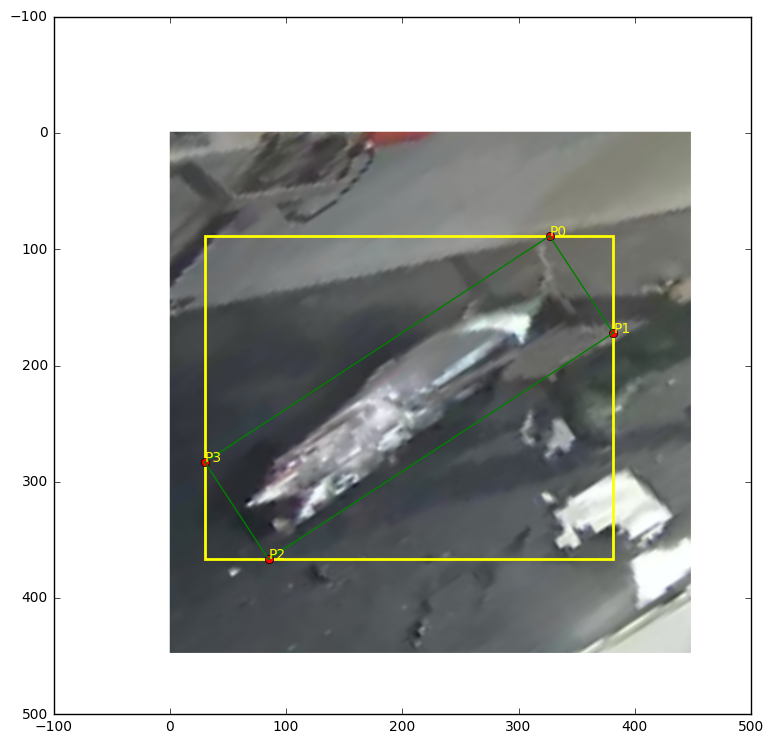

In [25]:
def plot(img):
    x = copy.copy(img)
    '''
    x = x + max(-np.min(x), 0)
    x_max = np.max(x)
    if x_max != 0:
        x /= x_max
    x *= 255
    '''
    plt.imshow(np.array(x, dtype=np.uint8))

def plot_box(a, b, c, d):
    ax = plt.gca()
    ax.text(a[0], a[1], 'P0', color='yellow')
    ax.text(b[0], b[1], 'P1', color='yellow')
    ax.text(c[0], c[1], 'P2', color='yellow')
    ax.text(d[0], d[1], 'P3', color='yellow')
    ax.plot(a[0], a[1], 'o', color='red')
    ax.plot(b[0], b[1], 'o', color='red')
    ax.plot(c[0], c[1], 'o', color='red')
    ax.plot(d[0], d[1], 'o', color='red')
    
    ax.plot([a[0], b[0]], [a[1], b[1]], color='green')
    ax.plot([b[0], c[0]], [b[1], c[1]], color='green')
    ax.plot([c[0], d[0]], [c[1], d[1]], color='green')
    ax.plot([d[0], a[0]], [d[1], a[1]], color='green')

    
def box_zoom(x, bb, zx, zy, theta = 0):
    """Performs zoom of a Numpy image tensor.
    # Arguments
        x: Input tensor (w, h, c).
        bb: Bounding box tuple (x, y, w, h)
        zx: zoom range for width.
        zy: zoom range for height.
    # Returns
        Zoomed Numpy image tensor.
    # Raises
        None
    """
    zcx = (bb[0] + bb[2] / 2.0 + 0.5)
    zcy = (bb[1] + bb[3] / 2.0 + 0.5)
    print('zoom center: ', zcx, zcy)
    
    box_tl = [bb[0], bb[1], 1]
    box_br = [bb[0] + bb[2], bb[1] + bb[3], 1]
    
    t1 = np.array([[1, 0, -zcx],
                   [0, 1, -zcy],
                   [0, 0, 1]])
    
    z = np.array([[zx, 0, 0],
                  [0, zy, 0],
                  [0, 0,  1]])
    
    r = np.array([[np.cos(-theta), -np.sin(-theta), 0],
                  [np.sin(-theta), np.cos(-theta), 0],
                  [0, 0, 1]])
    
    t = np.dot(r, np.dot(z, t1))
    v = np.array([box_br[0] - box_tl[0], 0, 1])
    
    box_tl = np.dot(t, box_tl)
    box_br = np.dot(t, box_br)
    v = np.dot(r, np.dot(z, v))
    
    t_box = np.array([box_tl, box_tl + v, box_br, box_br - v])
    
    tl_x = np.min([p[0] for p in t_box])
    tl_y = np.min([p[1] for p in t_box])
    br_x = np.max([p[0] for p in t_box])
    br_y = np.max([p[1] for p in t_box])
    
    min_translation = -1 * np.array([tl_x, tl_y])
    max_translation = x.shape[:2] - np.array([br_x, br_y])
    print('min: ', min_translation)
    print('max: ', max_translation)
    
    rtx = np.random.uniform(min_translation[0] + 0.5, max_translation[0] - 0.5)
    rty = np.random.uniform(min_translation[1] + 0.5, max_translation[1] - 0.5)
    t2 = np.array([[1, 0, rtx],
                   [0, 1, rty],
                   [0, 0, 1]])
    box_tl = np.dot(t2, box_tl)
    box_br = np.dot(t2, box_br)
    
    #t_box[0] = np.dot(t2, t_box[0])
    #t_box[1] = np.dot(t2, t_box[1])
    #t_box[2] = np.dot(t2, t_box[2])
    #t_box[3] = np.dot(t2, t_box[3])
    
    t_box = np.array([box_tl, box_tl + v, box_br, box_br - v])
    box_tl[0] = np.min([p[0] for p in t_box])
    box_tl[1] = np.min([p[1] for p in t_box])
    box_br[0] = np.max([p[0] for p in t_box])
    box_br[1] = np.max([p[1] for p in t_box]) 

    c = np.array([[1, 0, zcx],
                  [0, 1, zcy],
                  [0, 0, 1]])
        
    z = np.array([[1/zx, 0, 0],
                  [0, 1/zy, 0],
                  [0, 0, 1]])
    
    u = np.array([[1, 0, -rtx],
                  [0, 1, -rty],
                  [0, 0, 1]])
    
    r = np.array([[np.cos(theta), -np.sin(theta), 0],
                  [np.sin(theta), np.cos(theta), 0],
                  [0, 0, 1]])
    
    tc = transform.SimilarityTransform(matrix=c)
    tz = transform.SimilarityTransform(matrix=z)
    tr = transform.SimilarityTransform(matrix=r)
    tu = transform.SimilarityTransform(matrix=u)
    
    x = img_as_ubyte(transform.warp(x, tu + tr + tz + tc, mode='edge'))
    return x, [box_tl[0], box_tl[1], box_br[0] - box_tl[0], box_br[1] - box_tl[1]], t_box

def create_rect_xywh(box, color='red'):
    return plt.Rectangle((box[0], box[1]), box[2], box[3],
                         color=color, fill=False, linewidth=2)

def plot_bb(img, bb):
    plt.figure(figsize=(9, 12))
    plot(img)
    ax = plt.gca()
    print('Box (x,y,w,h): ', bb)
    if bb[2] > 0 and bb[3] > 0:
        ax.add_patch(create_rect_xywh(bb, 'yellow'))

img, bb, t_box = box_zoom(X_train[1], y_train_box[1], 3, 3, -0.99)
plot_bb(img, bb)
# plot_bb(X_train[1], y_train_box[1])
plot_box(t_box[0], t_box[1], t_box[2], t_box[3])

In [12]:
X_test, Id_test = \
    read_testing_images(config.testing_images_path)

Reading testing data...


KeyboardInterrupt: 

In [379]:
print('Saving training data...')
utils.save_array('X_train.bcolz', X_train)
utils.save_array('y_train.bcolz', y_train)
utils.save_array('y_train_box.bcolz', y_train_box)

# utils.save_array('X_test.bcolz', X_test)
# utils.save_array('Id_test.bcolz', Id_test)

Saving training data...


In [ ]:
print('Preprocessing X_train...')
vgg = create_vgg(config.img_w, config.img_h)
X_train_feat = predict(X_train, vgg, 8)

print('Preprocessing X_test...')
X_test_feat = predict(X_test, vgg, 8)

utils.save_array('X_train_feat.bcolz', X_train_feat)
utils.save_array('X_test_feat.bcolz', X_test_feat)